In [144]:
import numpy as np 
import stripy
import pickle
import os
import scipy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
from sklearn.neighbors import BallTree
from cartopy import feature as cfeature


PLOTS_DIR = "./plots"


INCH_OVER_CM = 2.54
PAGE_WIDTH = 14.8 / INCH_OVER_CM
PAGE_HEIGHT = 24.5 / INCH_OVER_CM


plt.rcParams.update({
    "font.size": 10,          # default text
    "axes.titlesize": 12,     # figure title
    "axes.labelsize": 10,     # x and y labels
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
})

plt.rcParams.update({
    "text.usetex": True,              # use LaTeX for all text
    "font.family": "serif",           # LaTeX serif font (Computer Modern by default)
    "axes.unicode_minus": False,      # ensure minus signs render correctly
})


%config InlineBackend.figure_format = 'retina'   # high quality
plt.rcParams["figure.dpi"] = 150

In [162]:
def create_figure(): 
    width = PAGE_WIDTH / 3
    height = width * 0.5

    fig = plt.figure(figsize=(width, height), facecolor="none")
    projection = ccrs.Mollweide()
    ax = plt.subplot(111, projection=projection)
    ax.coastlines(color="black", linewidth=0.75)
    return fig, ax


def save_figure(fig: plt.Figure, filename: str): 
    fig.savefig(os.path.join(PLOTS_DIR, filename), transparent=True, bbox_inches="tight")


def build_edge_collection(G: nx.Graph, alpha: float = 0.75, linewidth: float = 0.25, zorder: int = 0, color: str = "tab:grey") -> LineCollection: 
    lon = nx.get_node_attributes(G, 'longitude')
    lat = nx.get_node_attributes(G, 'latitude')
    lines = []
    for i, j in G.edges:
        lines.append([[lon[i], lat[i]], [lon[j], lat[j]]])
    return LineCollection(lines, colors=color, linewidths=linewidth, transform=ccrs.Geodetic(), zorder=zorder, alpha=alpha)


def plot_vertices(
    G: nx.Graph, 
    ax: plt.Axes, 
    alpha: float = 1.0, 
    s: float = 2.0, 
    marker: str = "o", 
    zorder: int = 1, 
    color: str = "tab:red", 
    c=None,
    cmap: str = "RdBu",
    colorbar_label: str = None,
) -> None: 
    if c is not None: 
        color = None
    lon = list(nx.get_node_attributes(G, 'longitude').values())
    lat = list(nx.get_node_attributes(G, 'latitude').values())
    map0 = ax.scatter(lon, lat, color=color, c=c, alpha=alpha, marker=marker, s=s, transform=ccrs.PlateCarree(), zorder=zorder, cmap=cmap, linewidths=0)

    # Add colorbar
    if c is not None: 
        plt.colorbar(map0, ax=ax, label=colorbar_label)



def plot_edges(G: nx.Graph, ax: plt.Axes, alpha: float = 0.75, linewidth: float = 0.25, zorder: int = 0, color: str = "tab:grey") -> None: 
    ax.add_collection(build_edge_collection(G, alpha, linewidth, zorder, color))

In [96]:
def stripy_to_networkx(mesh: stripy.spherical_meshes.icosahedral_mesh) -> nx.Graph: 
    G = nx.Graph()
    G.add_nodes_from(range(len(mesh.lons)))
    for i, j in mesh.identify_segments():
        G.add_edge(i, j)
    df_lonlat = pd.DataFrame(np.stack([np.degrees(mesh.lons), np.degrees(mesh.lats)], axis=-1), columns=["longitude", "latitude"])
    nx.set_node_attributes(G, df_lonlat.to_dict(orient="index"))
    return G

# 1. Earth mesh with observations

### Create mesh

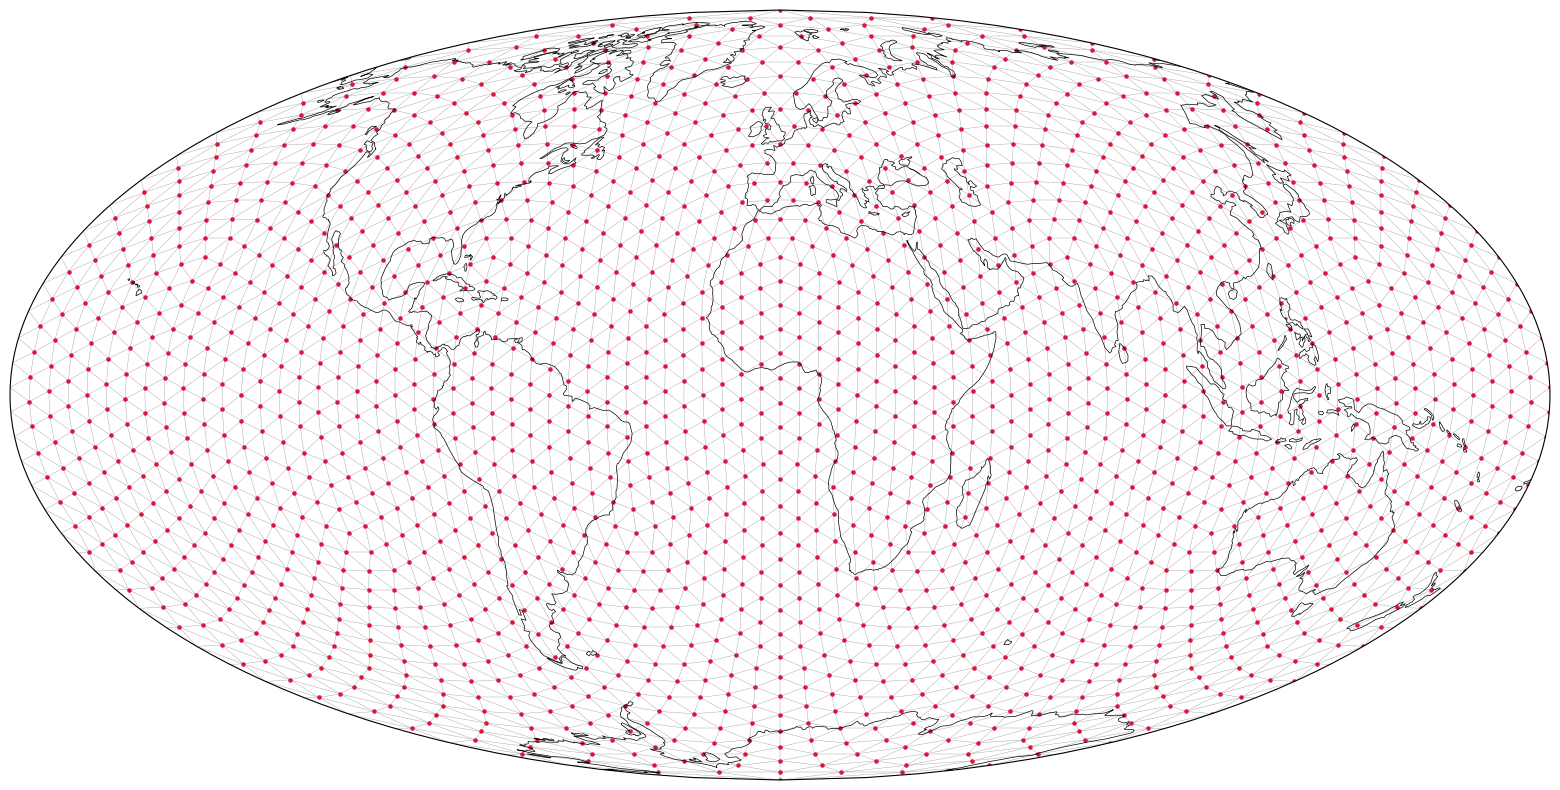

In [97]:
### Create mesh 
mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=3, include_face_points=True, tree=True)
df_mesh = pd.DataFrame(np.stack([np.degrees(mesh.lons), np.degrees(mesh.lats)], axis=-1), columns=["longitude", "latitude"])


### Plot
fig = plt.figure(figsize=(20, 10), facecolor="none")
projection = ccrs.Mollweide()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.5)

# Create LineCollection
segs = mesh.identify_segments()
lines = df_mesh.values[segs]
lc = LineCollection(lines, colors="dimgrey", linewidths=0.25, alpha=0.75, transform=ccrs.Geodetic(), zorder=0)
ax.add_collection(lc)

# Scatter points
ax.scatter(*df_mesh.values.T, color="crimson", alpha=1.0, marker="o", s=5.0, transform=ccrs.PlateCarree(), zorder=1)

### Load raw events

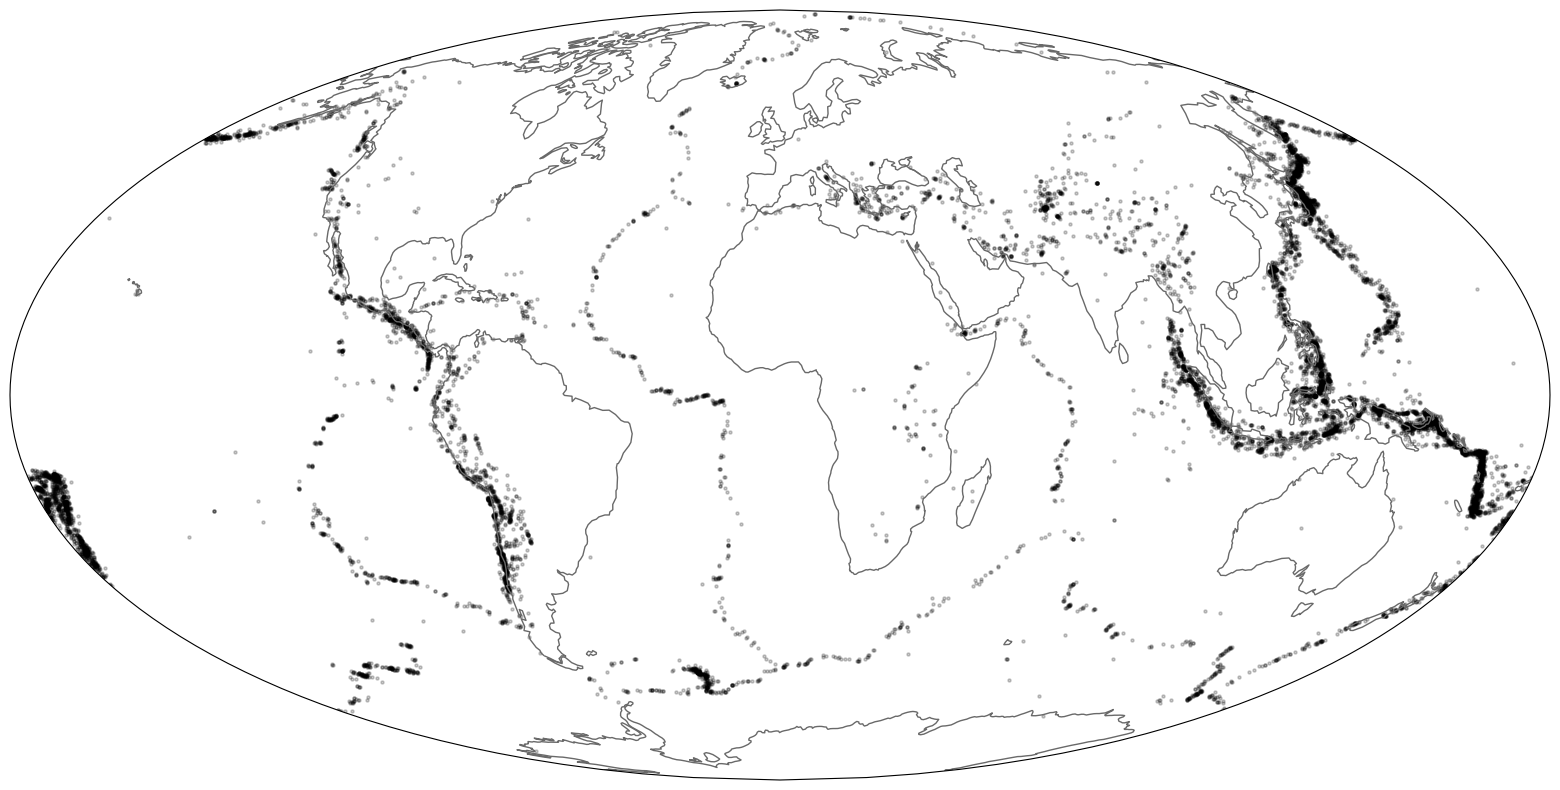

In [98]:
df_events = pd.read_csv('raw_events.csv')

### Plot
fig = plt.figure(figsize=(20, 10), facecolor="none")
projection = ccrs.Mollweide()
ax  = plt.subplot(111, projection=projection)

# Add features 
ax.coastlines(color="dimgrey")
ax.scatter(df_events['longitude'], df_events['latitude'], color="black", alpha=0.2, marker="o", s=5.0, transform=ccrs.PlateCarree(), zorder=1)

### Combinate into one plot

In [100]:
PAGE_WIDTH

5.826771653543307

In [104]:
PAGE_WIDTH * INCH_OVER_CM

14.8

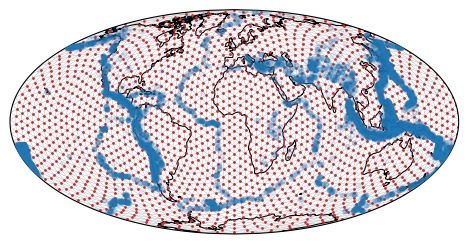

In [105]:
### Plot
width = PAGE_WIDTH
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Mollweide()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.75)

# Create LineCollection
segs = mesh.identify_segments()
lines = df_mesh.values[segs]
lc = LineCollection(lines, colors="tab:grey", linewidths=0.25, alpha=0.75, transform=ccrs.Geodetic(), zorder=1)
ax.add_collection(lc)

# Scatter vertices
ax.scatter(*df_mesh.values.T, color="tab:red", alpha=1.0, marker="o", s=1.0, transform=ccrs.PlateCarree(), zorder=2)

# Scatter events
ax.scatter(df_events['longitude'], df_events['latitude'], color="tab:blue", alpha=0.1, marker="o", s=10.0, transform=ccrs.PlateCarree(), zorder=3)

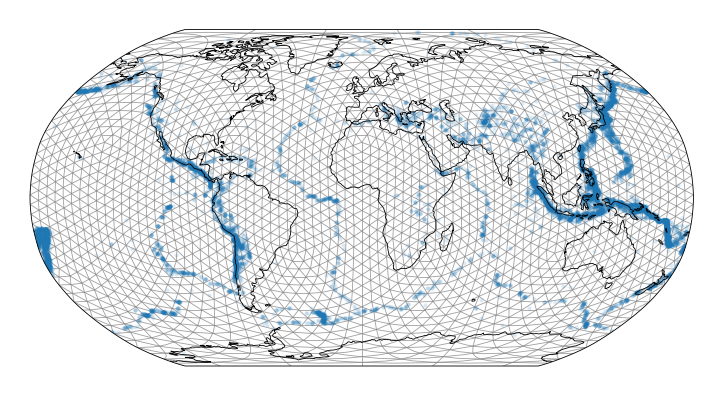

In [165]:
### Plot
width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)


G_mesh = stripy_to_networkx(mesh)
plot_edges(G_mesh, ax, linewidth=0.20)
# plot_vertices(G_mesh, ax, s=0.05)
ax.scatter(df_events['longitude'], df_events['latitude'], color="tab:blue", alpha=0.15, marker="o", s=1.0, transform=ccrs.PlateCarree(), zorder=0, linewidths=0)


# figure stuff

save_figure(fig, "icosahedral_mesh_with_events.pdf")

# 2. Earth knn graph

### Get the closest vertices and plot them

In [168]:
# NOTE the commented version would better since haversine, but maosheng uses the euclidean distance
event_latlon = np.radians(df_events[["latitude", "longitude"]].values)
mesh_latlon = np.radians(df_mesh[['latitude', 'longitude']].values)
tree = BallTree(mesh_latlon, metric="haversine")
_, idx = tree.query(event_latlon, k=1)

# _, idx = mesh.nearest_vertices(
#     lon=np.radians(df_events['longitude']), 
#     lat=np.radians(df_events['latitude']), 
#     k=1,
# )
print("Number of unique vertices:", len(np.unique(idx)))


# Add results to DataFrame (store vertex coords in degrees for readability)
df_events["closest_mesh_idx"] = idx
df_events["closest_mesh_lon"] = np.rad2deg(mesh.lons[idx])
df_events["closest_mesh_lat"] = np.rad2deg(mesh.lats[idx])

df_graph = df_mesh.iloc[df_events['closest_mesh_idx'].unique()]


Number of unique vertices: 576


/home/kacperwyrwal/topological-flow-matching/stripy-venv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


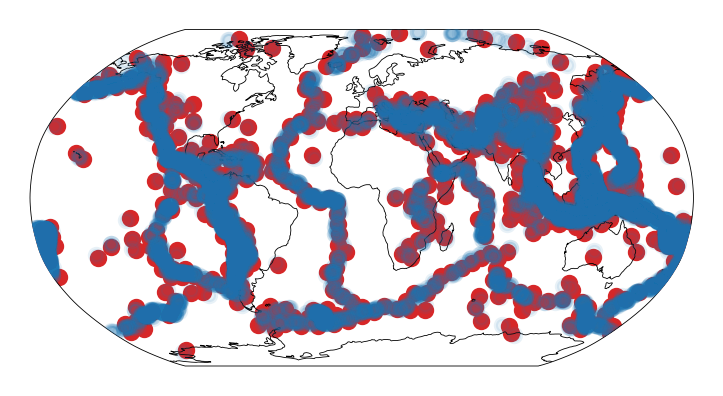

In [154]:
### Plot
width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)

G = nx.subgraph(G_mesh, df_graph.index)
# plot_edges(G, ax)
plot_vertices(G, ax, s=10.0)
ax.scatter(df_events['longitude'], df_events['latitude'], color="tab:blue", alpha=0.1, marker="o", s=10.0, transform=ccrs.PlateCarree(), zorder=3)

In [158]:
# Take the closest k vertices to each vertex
graph_latlon = np.radians(df_graph[["latitude", "longitude"]].values)
tree = BallTree(graph_latlon, metric="haversine")
_, knn_idx = tree.query(graph_latlon, k=11) # Take eleven neighbours and then remove self 
knn_idx = knn_idx[:, 1:] # remove self

# Create adjacency matrix
A = np.zeros((len(df_graph), len(df_graph)))
for i, v in enumerate(df_graph.index):
    A[i, knn_idx[i]] = 1


G = nx.from_numpy_array(A)
nx.set_node_attributes(G, df_graph[['longitude', 'latitude']].reset_index(drop=True).to_dict(orient='index'))

/home/kacperwyrwal/topological-flow-matching/stripy-venv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1677: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  result = super().scatter(*args, **kwargs)


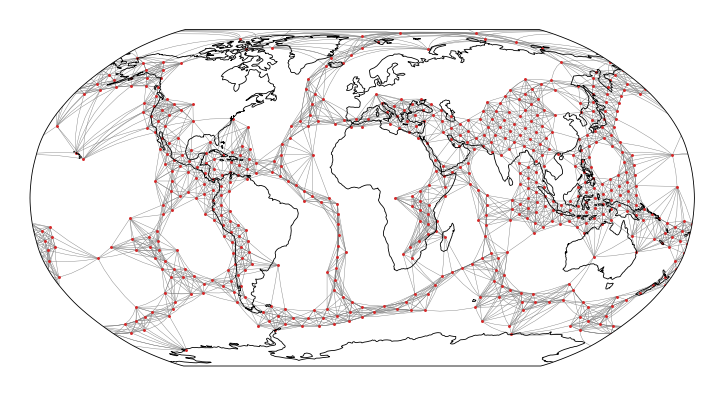

In [166]:
# Create LineCollection
width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)


plot_vertices(G, ax, s=0.5)
plot_edges(G, ax, alpha=1.0, linewidth=0.1)

save_figure(fig, "knn_graph.pdf")

# Input and Output

In [169]:
def get_agg_fn(collate: str = "mean"): 
    if collate == "mean": 
        agg_fn = np.mean
    elif collate == "median": 
        agg_fn = np.median
    elif collate == "max": 
        agg_fn = np.max
    elif collate == "min": 
        agg_fn = np.min
    elif collate == "last": 
        agg_fn = lambda x: x.iloc[-1]
    elif collate == "first": 
        agg_fn = lambda x: x.iloc[0]
    return agg_fn


def to_data(df: pd.DataFrame, agg: str = "mean") -> np.ndarray: 
    assert agg in ["mean", "median", "max", "min", "last", "first"]

    # Create the aggregation function
    agg_fn = get_agg_fn(agg)
    
    # Group by year and vertex_idx, then aggregate the magnitude
    df = df.copy() 

    # Create the data array
    num_vertices = len(np.unique(df["idx"]))
    idx_name = "idx"

    df = df.groupby(["year", idx_name])[["magnitude"]].agg(agg_fn).reset_index()


    data = np.zeros((29, num_vertices))
    for year in range(1990, 2019):
        data[year - 1990, df.query("year == @year")[idx_name]] = df.query("year == @year")["magnitude"].values

    return data


def preprocess(df: pd.DataFrame) -> pd.DataFrame: 
    df = df.copy()
    g = df['magnitude']
    g_mean = g.mean(axis=0)
    g_min = g.min() 
    g_max = g.max() 
    g = (g - g_mean)
    g = (g - g_min) / (g_max - g_min)
    df['magnitude'] = g
    return df 


agg = "median"
agg_fn = get_agg_fn(agg)
df_events_agg = df_events.groupby(["year", "closest_mesh_idx"])[["magnitude"]].agg(agg_fn).reset_index()

data = np.zeros((29, len(df_graph))) 
for year in range(1990, 2019): 
    idx = df_graph.index.get_indexer(df_events_agg.query("year == @year")["closest_mesh_idx"])
    data[year - 1990, idx] = df_events_agg.query("year == @year")["magnitude"].values

df_events_processed = pd.DataFrame(
    data, columns=df_graph.index
).melt(
    ignore_index=False, var_name="mesh_idx", value_name="magnitude"
).reset_index().rename(
    columns={"index": "year"}
).assign(
    year=lambda x: x["year"] + 1990
)

df_events_processed = preprocess(df_events_processed)

/tmp/ipykernel_1441/3417324504.py:54: FutureWarning: The provided callable <function median at 0x7d2e705e8280> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_events_agg = df_events.groupby(["year", "closest_mesh_idx"])[["magnitude"]].agg(agg_fn).reset_index()


In [204]:
mesh.npoints

1922

### Input

In [195]:
x1 = df_events_processed.query("year == 2008")["magnitude"]

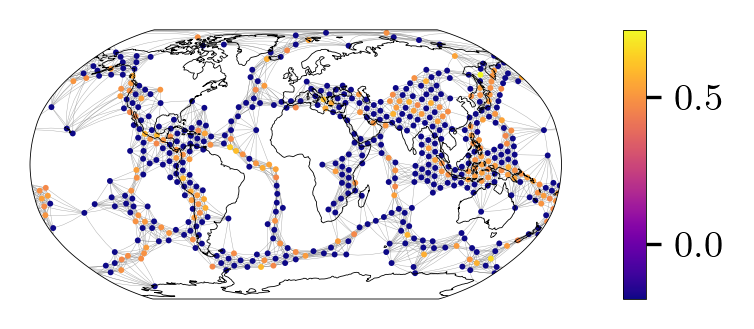

In [200]:
# Create LineCollection
width = PAGE_WIDTH / 2
height = width * 0.4

fig = plt.figure(figsize=(width, height), facecolor="none")
gs = fig.add_gridspec(1, 2, width_ratios=[1, 0.035], wspace=0.0)

projection = ccrs.Robinson()
ax = fig.add_subplot(gs[0], projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)


alpha = 1.0
s = 2.0
marker = 'o'
cmap = 'plasma'
zorder = 1
lon = list(nx.get_node_attributes(G, 'longitude').values())
lat = list(nx.get_node_attributes(G, 'latitude').values())
scatter = ax.scatter(lon, lat, c=x1, alpha=alpha, marker=marker, s=s, transform=ccrs.PlateCarree(), zorder=zorder, cmap=cmap, linewidths=0)


cax = fig.add_subplot(gs[1])
cbar = fig.colorbar(scatter, cax=cax)
cbar.outline.set_linewidth(0.2)   # default is ~1.0

plot_edges(G, ax, alpha=0.7, linewidth=0.1)

save_figure(fig, "graph_with_node_features.pdf")

In [202]:
for lbl in cbar.ax.get_yticklabels():
    print(lbl.get_fontsize())

9.0
9.0
9.0
9.0


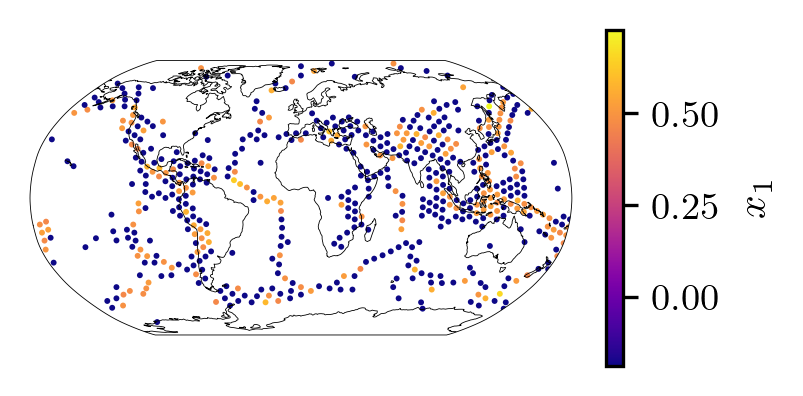

In [ ]:
width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)


plot_vertices(G, ax, c=x1, s=2.0, colorbar_label=r"$x_1$", cmap='plasma')
# plot_edges(G, ax, alpha=0.5)

save_figure(fig, "output_processed_2008.pdf")

### Output

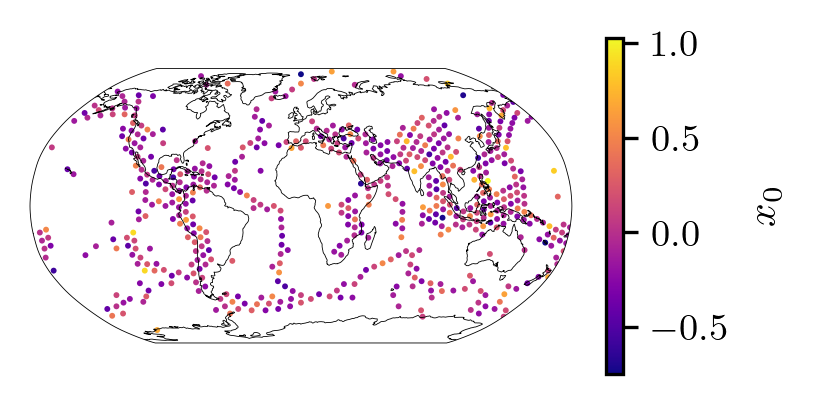

In [173]:
vertex_stats = df_events_processed.groupby("mesh_idx")['magnitude'].agg(['std', 'mean'])
x0 = np.random.randn(len(df_graph))
x0 = x0 * vertex_stats['std'] + vertex_stats['mean']


width = PAGE_WIDTH / 2
height = width * 0.5

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson()
ax = plt.subplot(111, projection=projection)
ax.coastlines(color="black", linewidth=0.2, zorder=3)
ax.spines['geo'].set_linewidth(0.2)

plot_vertices(G, ax, c=x0, s=2.0, colorbar_label=r"$x_0$", cmap='plasma')

save_figure(fig, "input_2008.pdf")

# Combine input and output side by side

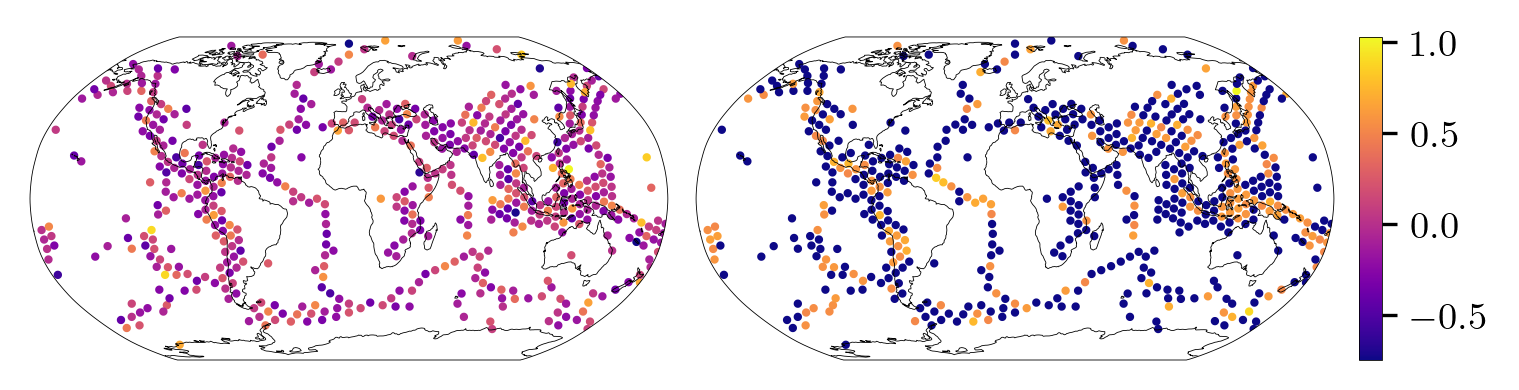

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx

# your sizing
width = PAGE_WIDTH
height = width * 0.24

fig = plt.figure(figsize=(width, height), facecolor="none")
projection = ccrs.Robinson()

gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.035], wspace=0.05)
ax0 = fig.add_subplot(gs[0], projection=projection)
ax0.coastlines(color="black", linewidth=0.2, zorder=3)
ax0.spines['geo'].set_linewidth(0.2)

ax1 = fig.add_subplot(gs[1], projection=projection)
ax1.coastlines(color="black", linewidth=0.2, zorder=3)
ax1.spines['geo'].set_linewidth(0.2)


# settings for the plots
alpha = 1.0
s = 1.0
cmap = 'plasma'
zorder = 1


# INPUT

lon = list(nx.get_node_attributes(G, 'longitude').values())
lat = list(nx.get_node_attributes(G, 'latitude').values())
scatter0 = ax0.scatter(lon, lat, c=x0, alpha=alpha, marker='o', s=s,
                       transform=ccrs.PlateCarree(), zorder=zorder, cmap=cmap)

# OUTPUT
lon = list(nx.get_node_attributes(G, 'longitude').values())
lat = list(nx.get_node_attributes(G, 'latitude').values())
scatter1 = ax1.scatter(lon, lat, c=x1, alpha=alpha, marker='o', s=s,
                       transform=ccrs.PlateCarree(), zorder=zorder, cmap=cmap)

# dedicated colorbar axis (third column of GridSpec)
cax = fig.add_subplot(gs[2])
cbar = fig.colorbar(scatter0, cax=cax)
cbar.outline.set_linewidth(0.2)   # default is ~1.0


# save
save_figure(fig, "input_output_side_by_side.pdf")

# Request the data

In [ ]:
import requests, pandas as pd
from io import StringIO
from sklearn.neighbors import BallTree


# url = (
#     "https://earthquake.usgs.gov/fdsnws/event/1/query?"
#     "starttime=1990-01-01&endtime=2018-02-19&"
#     "minmagnitude=5.5&"
#     "eventtype=earthquake&"
#     "orderby=time-asc&"
#     "format=csv&"
#     "nodata=404"
# )

url = (
    "https://service.iris.edu/fdsnws/event/1/query?"
    "starttime=1990-01-01&"
    "endtime=2018-02-19T23%3A59%3A59.999999&"
    "minmagnitude=5.5&"
    # "maxmagnitude=10&"
    # "minlatitude=-90.0&"
    # "maxlatitude=90.0&"
    # "minlongitude=-180.0&"
    # "maxlongitude=180.0&"
    "mindepth=0&"
    "maxdepth=100000&"
    "output=text&"
    "nodata=404"
)


r = requests.get(url, timeout=60)
r.raise_for_status()
df = pd.read_csv(StringIO(r.text), delimiter="|")
print(f"Loaded {len(df)} events")


# Strip spaces from the column names
df.columns = df.columns.str.strip()

# Take only the relevant columns
df = df[['#EventID', 'Time', 'Latitude', 'Longitude', 'Magnitude']]

# Basic preprocessing
df = df.rename(
    columns={'#EventID': 'ID', 'Time': 'time', 'Latitude': 'latitude', 'Longitude': 'longitude', 'Magnitude': 'magnitude'}
).assign(
    time=lambda x: pd.to_datetime(x['time'])
).assign(
    year=lambda x: x['time'].dt.year
)

df.to_csv('./raw_events.csv', index=False)

# Plot the events to make sure they align with Maosheng's before preprocessing

/tmp/ipykernel_1441/2116586287.py:42: FutureWarning: The provided callable <function median at 0x7d2e705e8280> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_events_agg = df_events.groupby(["year", "closest_mesh_idx"])[["magnitude"]].agg(agg_fn).reset_index()


0.17121925458401752

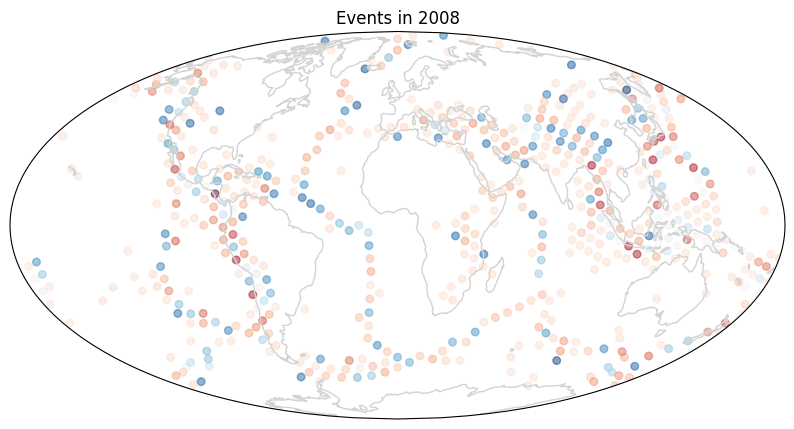

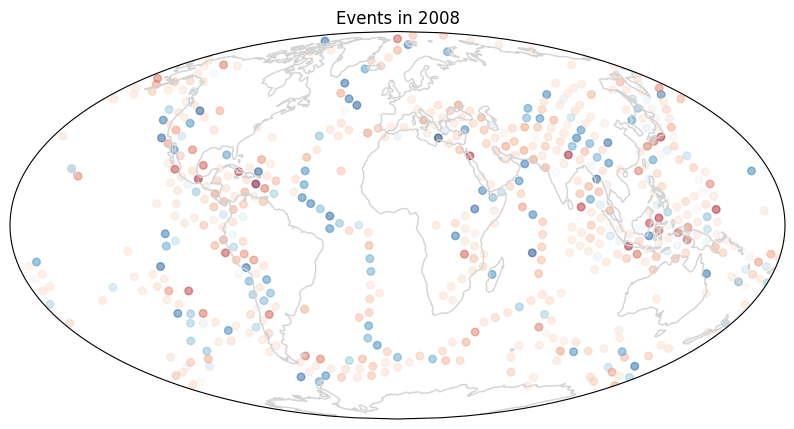

In [13]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey")
ax.set_global()


# lonslats = event_lonlat
# data = data_event

lonslats = event_lonlat
data = g


year = 2008
x = lonslats[:, 0]
y = lonslats[:, 1]
c = data[year-1990]
ax.scatter(
    x, 
    y, 
    c=c, 
    marker="o", 
    s=30.0, 
    transform=ccrs.PlateCarree(), 
    cmap=plt.cm.RdBu, 
    # vmin=0.333, 
    # vmin=1.0,
    # vmax=10.0,
    alpha=0.5, 
    zorder=1,
)
# ax.add_collection(lc)
plt.title(f"Events in {year}")
plt.show()




#######


fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey")
ax.set_global()


# lonslats = event_lonlat
# data = data_event

lonslats = event_lonlat
data = maosheng_data


year = 2008
x = lonslats[:, 0]
y = lonslats[:, 1]
c = data[year-1990]
ax.scatter(
    x, 
    y, 
    c=c, 
    marker="o", 
    s=30.0, 
    transform=ccrs.PlateCarree(), 
    cmap=plt.cm.RdBu, 
    # vmin=0.333, 
    # vmin=1.0,
    # vmax=10.0,
    alpha=0.5, 
    zorder=1,
)
# ax.add_collection(lc)
plt.title(f"Events in {year}")
plt.show()

# 4. Automate the rest of the preprocessing

In [14]:
data_processed = to_data(df, collate="last", vertices="events")
data_processed = data_processed - data_processed.mean(axis=0)

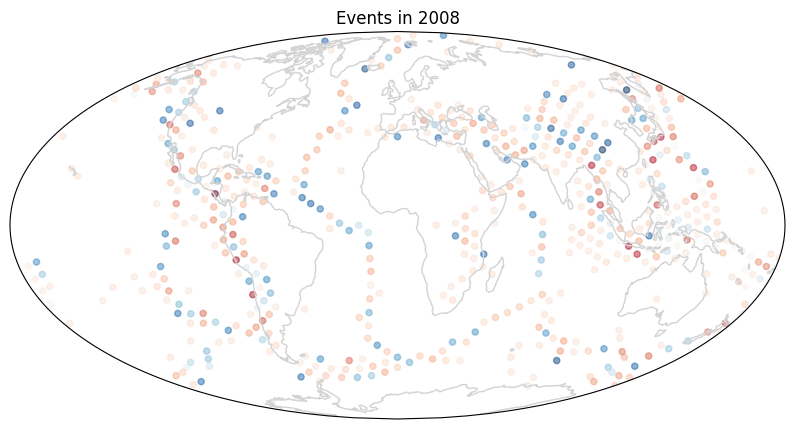

In [15]:
fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Mollweide())
ax.coastlines(color="lightgrey")
ax.set_global()


lonslats = event_lonlat
data = data_processed


year = 2008
x = lonslats[:, 0]
y = lonslats[:, 1]
c = data[year-1990]
ax.scatter(
    x, 
    y, 
    c=c, 
    marker="o", 
    s=20.0, 
    transform=ccrs.PlateCarree(), 
    cmap=plt.cm.RdBu, 
    # vmin=0.333, 
    # vmin=1.0,
    # vmax=10.0,
    alpha=0.5, 
    zorder=1,
)
# ax.add_collection(lc)
plt.title(f"Events in {year}")
plt.show()

In [340]:
for collate in ["mean", "median", "max", "min", "last", "first"]: 
    print(f"Collating by {collate}".center(80, "-"))
    data_processed = to_data(df, collate=collate, vertices="events")
    print(f"Removing mean at each node gives error: {np.mean(np.abs((data_processed - data_processed.mean(axis=0)) - maosheng_data))}")
    print(f"Removing mean magnitude from all years gives error: {np.mean(np.abs((data_processed - data_processed.mean()) - maosheng_data))}")
    print(f"Removing mean magnitude from each year gives error: {np.mean(np.abs((data_processed - data_processed.mean(axis=1)[:, None]) - maosheng_data))}")

-------------------------------Collating by mean--------------------------------
Removing mean at each node gives error: 1.3865182164517473
Removing mean magnitude from all years gives error: 2.266690113251212
Removing mean magnitude from each year gives error: 2.2401496632025406
------------------------------Collating by median-------------------------------
Removing mean at each node gives error: 1.3836730413528868
Removing mean magnitude from all years gives error: 2.2562673357983534
Removing mean magnitude from each year gives error: 2.229887623377985
--------------------------------Collating by max--------------------------------
Removing mean at each node gives error: 1.4229961044894903
Removing mean magnitude from all years gives error: 2.3519390105572384
Removing mean magnitude from each year gives error: 2.3241411090040907
--------------------------------Collating by min--------------------------------


/tmp/ipykernel_2667/3846171170.py:30: FutureWarning: The provided callable <function mean at 0x77a05814e950> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(["year", idx_name])[["magnitude"]].agg(agg_fn).reset_index()
/tmp/ipykernel_2667/3846171170.py:30: FutureWarning: The provided callable <function median at 0x77a05807cdc0> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df = df.groupby(["year", idx_name])[["magnitude"]].agg(agg_fn).reset_index()
/tmp/ipykernel_2667/3846171170.py:30: FutureWarning: The provided callable <function max at 0x77a05814e050> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "m

Removing mean at each node gives error: 1.364908120096698
Removing mean magnitude from all years gives error: 2.2123841949533865
Removing mean magnitude from each year gives error: 2.1865522446263883
-------------------------------Collating by last--------------------------------
Removing mean at each node gives error: 1.3974281913931514
Removing mean magnitude from all years gives error: 2.2767399633196024
Removing mean magnitude from each year gives error: 2.250033584858177
-------------------------------Collating by first-------------------------------
Removing mean at each node gives error: 1.3847733343320812
Removing mean magnitude from all years gives error: 2.258518783360412
Removing mean magnitude from each year gives error: 2.2320053297157876


# Construct graph and plot

In [108]:
def build_edge_collection(G: nx.Graph) -> LineCollection: 
    pos = nx.get_node_attributes(G, 'pos')
    lines = []
    for i, j in G.edges:
        lines.append([pos[i], pos[j]])
    return LineCollection(lines, colors="grey", linewidths=0.25, transform=ccrs.Geodetic(), zorder=0, alpha=0.75)


def plot_vertices(G: nx.Graph, ax: plt.Axes) -> None: 
    pos = nx.get_node_attributes(G, 'pos')
    lons = np.array([p[0] for p in pos.values()])
    lats = np.array([p[1] for p in pos.values()])
    ax.scatter(lons, lats, color="crimson", alpha=1.0, marker="o", s=2.0, transform=ccrs.PlateCarree(), zorder=1)


def plot_edges(G: nx.Graph, ax: plt.Axes) -> None: 
    ax.add_collection(build_edge_collection(G))

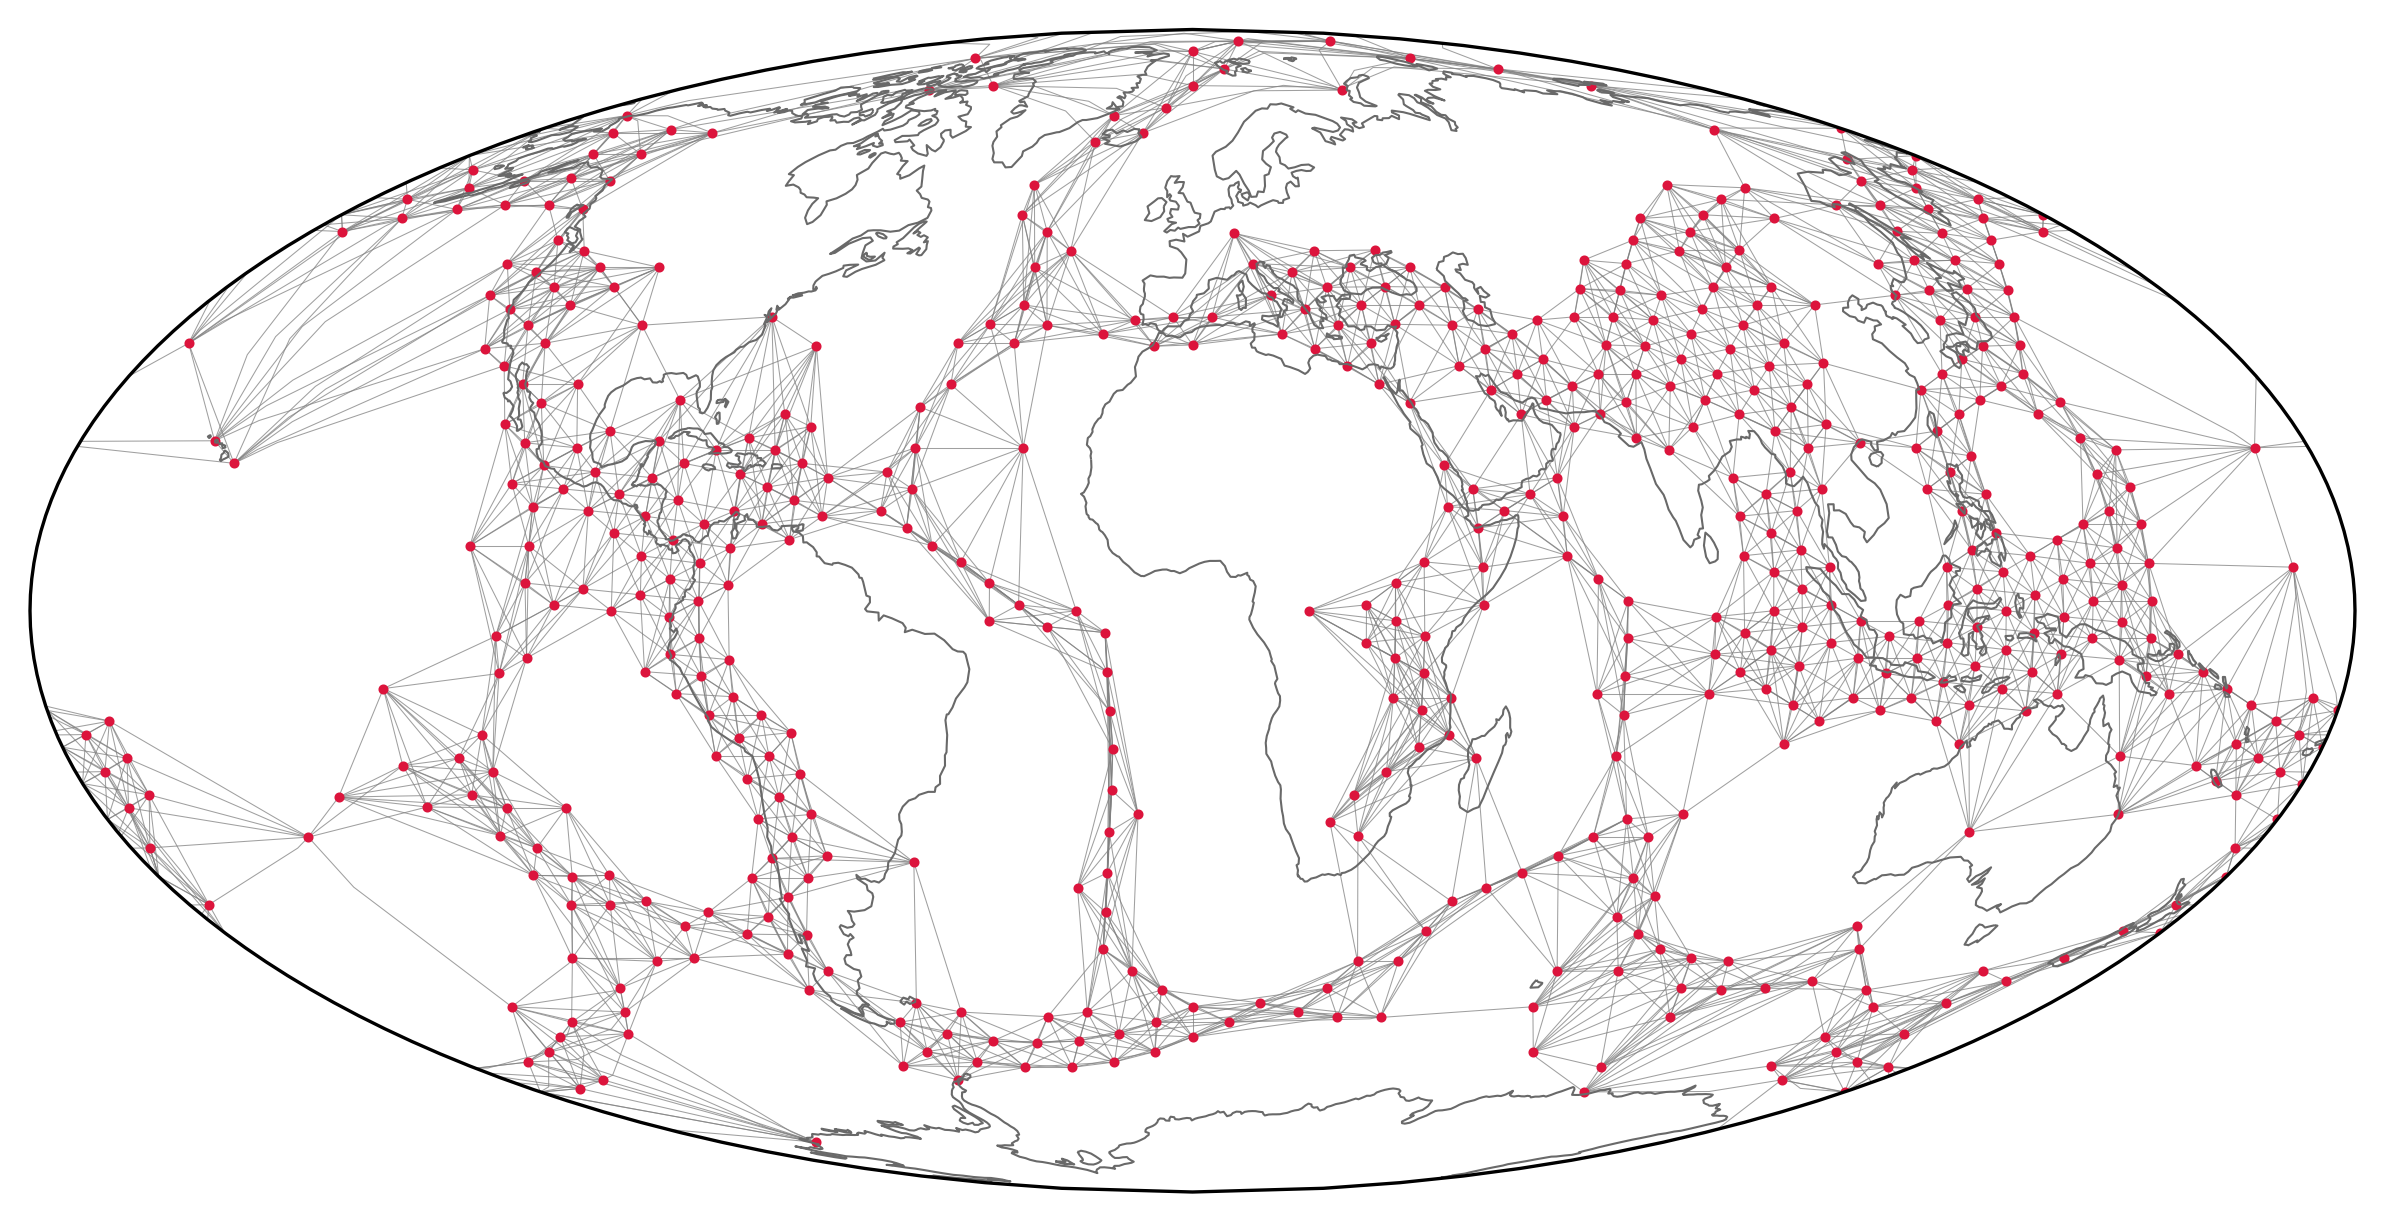

In [109]:
# Draw the graph 
fig = plt.figure(figsize=(10, 6), facecolor="none", dpi=300)
# projection = ccrs.Orthographic()
projection = ccrs.Mollweide()
ax  = plt.subplot(111, projection=projection)
ax.coastlines(color="dimgrey", linewidth=0.5)

# Draw points and lines 
plot_vertices(G, ax)
plot_edges(G, ax)